In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import glob, os

## Briefly explain how can you pose the given task into the form of a function. 

The classification problem is expressed as a function that maps a feature vector extracted from a 200×200 Sentinel-2 patch to a binary label (urban = 1, forest = 0). This turns image interpretation into a numerical mapping 
𝑓:𝑅^6→{0,1}, which a neural network can learn.

## What is the baritone ANN architecture you will need for this problem? 

The baseline ANN uses six input neurons (mean and standard deviation of NDVI, NDBI, NDWI), one hidden layer with 16 ReLU units, and a single sigmoid output neuron.

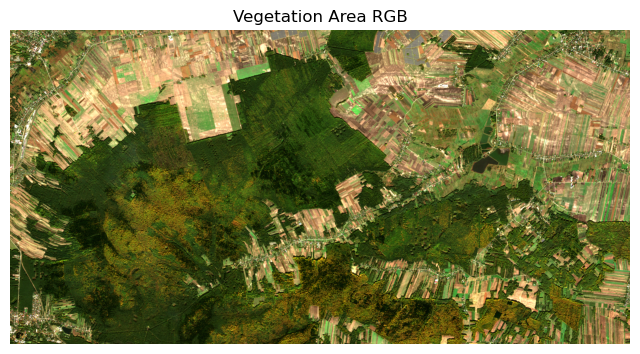

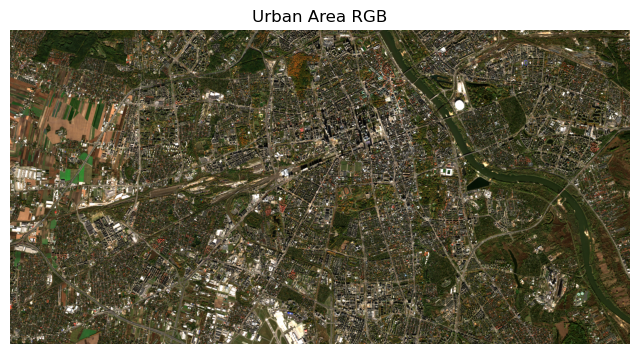

In [11]:
def match_band_to_ref(ref_path, folder, pattern):

    files = glob.glob(os.path.join(folder, pattern))
    src_path = files[0]

    with rasterio.open(ref_path) as ref:
        ref_profile = ref.profile
        dst = np.empty((ref.height, ref.width), dtype=np.float32)

        with rasterio.open(src_path) as src:
            reproject(
                source=rasterio.band(src, 1),
                destination=dst,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=ref.transform,
                dst_crs=ref.crs,
                dst_height=ref.height,
                dst_width=ref.width,
                resampling=Resampling.bilinear,
            )

    return dst

veg_ref = "vegetation.tif"
veg_folder = "vegetation_data"

V_B03 = match_band_to_ref(veg_ref, veg_folder, "*_B03_20m.jp2")   # Green
V_B04 = match_band_to_ref(veg_ref, veg_folder, "*_B04_20m.jp2")   # Red
V_B8A = match_band_to_ref(veg_ref, veg_folder, "*_B8A_20m.jp2")   # 8A because 08 is not available
V_B11 = match_band_to_ref(veg_ref, veg_folder, "*_B11_20m.jp2")   # SWIR

urb_ref = "urban.tif"
urb_folder = "urban_data"

U_B03 = match_band_to_ref(urb_ref, urb_folder, "*_B03_20m.jp2")
U_B04 = match_band_to_ref(urb_ref, urb_folder, "*_B04_20m.jp2")
U_B8A = match_band_to_ref(urb_ref, urb_folder, "*_B8A_20m.jp2")
U_B11 = match_band_to_ref(urb_ref, urb_folder, "*_B11_20m.jp2")

def ndvi(NIR, RED):
    return (NIR - RED) / (NIR + RED + 1e-6)

def ndbi(SWIR, NIR):
    return (SWIR - NIR) / (SWIR + NIR + 1e-6)

def ndwi(G, NIR):
    return (G - NIR) / (G + NIR + 1e-6)

V_NDVI = ndvi(V_B8A, V_B04)
V_NDBI = ndbi(V_B11, V_B8A)
V_NDWI = ndwi(V_B03, V_B8A)

U_NDVI = ndvi(U_B8A, U_B04)
U_NDBI = ndbi(U_B11, U_B8A)
U_NDWI = ndwi(U_B03, U_B8A)

with rasterio.open("vegetation.tif") as src:
    veg = src.read()

veg = veg.astype(np.float32)
veg /= np.percentile(veg, 99)
veg = np.clip(veg, 0, 1)

veg = np.transpose(veg, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(veg)
plt.title("Vegetation Area RGB")
plt.axis("off")
plt.show()

with rasterio.open("urban.tif") as src:
    urb = src.read()

urb = urb.astype(np.float32)
urb /= np.percentile(urb, 99)
urb = np.clip(urb, 0, 1)

urb = np.transpose(urb, (1, 2, 0))

plt.figure(figsize=(8, 8))
plt.imshow(urb)
plt.title("Urban Area RGB")
plt.axis("off")
plt.show()

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ---- CONFIG ----
PATCH_SIZE = 200          # 200x200 pixels
N_PATCHES_PER_CLASS = 200 # how many patches per class (tune if needed)
RNG = np.random.default_rng(42)

def sample_patch_coords(h, w, size=PATCH_SIZE, rng=RNG):
    """Random top-left corner of a size×size patch inside an image."""
    if h < size or w < size:
        raise ValueError(f"Image {h}x{w} smaller than patch {size}x{size}")
    row = rng.integers(0, h - size)
    col = rng.integers(0, w - size)
    return row, col

def patch_to_features(ndvi, ndbi, ndwi, row, col, size=PATCH_SIZE):
    """
    Turn a patch into a feature vector.
    Here: mean and std of NDVI, NDBI, NDWI → 6 features.
    You can add more (bands, texture, etc.).
    """
    r0, r1 = row, row + size
    c0, c1 = col, col + size

    patches = [
        ndvi[r0:r1, c0:c1],
        ndbi[r0:r1, c0:c1],
        ndwi[r0:r1, c0:c1],
    ]
    feats = []
    for p in patches:
        feats.append(np.nanmean(p))
        feats.append(np.nanstd(p))
    return np.array(feats, dtype=np.float32)

# ---- Build X, y from vegetation & urban indices ----
X = []
y = []

# vegetation image shape
H_v, W_v = V_NDVI.shape
H_u, W_u = U_NDVI.shape

for _ in range(N_PATCHES_PER_CLASS):
    r, c = sample_patch_coords(H_v, W_v)
    feats = patch_to_features(V_NDVI, V_NDBI, V_NDWI, r, c)
    if not np.any(np.isnan(feats)):
        X.append(feats)
        y.append(0)

for _ in range(N_PATCHES_PER_CLASS):
    r, c = sample_patch_coords(H_u, W_u)
    feats = patch_to_features(U_NDVI, U_NDBI, U_NDWI, r, c)
    if not np.any(np.isnan(feats)):
        X.append(feats)
        y.append(1)

X = np.vstack(X)
y = np.array(y)

print("Dataset shape:", X.shape)


Dataset shape: (400, 6)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)


Train: (320, 6) Test: (80, 6)


In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

configs = [
    {
        "name": "Baseline_1x16_Adam",
        "hidden_layer_sizes": (16,),
        "activation": "relu",
        "solver": "adam"
    },
    {
        "name": "Bigger_1x32_Adam",
        "hidden_layer_sizes": (32,),
        "activation": "relu",
        "solver": "adam"
    },
    {
        "name": "Deeper_32_16_Adam",
        "hidden_layer_sizes": (32, 16),
        "activation": "relu",
        "solver": "adam"
    },
    {
        "name": "Tanh_32_16_Adam",
        "hidden_layer_sizes": (32, 16),
        "activation": "tanh",
        "solver": "adam"
    },
    {
        "name": "Baseline_1x16_SGD",
        "hidden_layer_sizes": (16,),
        "activation": "relu",
        "solver": "sgd"
    },
]

results = []
trained_models = {}   # <--- add this

for cfg in configs:
    print("=" * 60)
    print("Training:", cfg["name"])
    
    mlp = MLPClassifier(
        hidden_layer_sizes=cfg["hidden_layer_sizes"],
        activation=cfg["activation"],
        solver=cfg["solver"],
        alpha=1e-4,
        learning_rate_init=1e-3 if cfg["solver"] == "adam" else 1e-2,
        max_iter=400,
        random_state=42
    )

    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Test accuracy: {acc:.3f}")
    print("Confusion matrix (rows=true, cols=predicted):")
    print(cm)
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=["vegetation", "urban"]))

    results.append({
        "name": cfg["name"],
        "hidden_layers": cfg["hidden_layer_sizes"],
        "activation": cfg["activation"],
        "solver": cfg["solver"],
        "test_accuracy": acc
    })
    
    trained_models[cfg["name"]] = mlp   # <--- store model here

results_df = pd.DataFrame(results)
results_df



Training: Baseline_1x16_Adam


c:\Users\Hp\miniconda3\envs\RemoteSensing\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy: 1.000
Confusion matrix (rows=true, cols=predicted):
[[40  0]
 [ 0 40]]
Classification report:
              precision    recall  f1-score   support

  vegetation       1.00      1.00      1.00        40
       urban       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Training: Bigger_1x32_Adam


c:\Users\Hp\miniconda3\envs\RemoteSensing\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy: 1.000
Confusion matrix (rows=true, cols=predicted):
[[40  0]
 [ 0 40]]
Classification report:
              precision    recall  f1-score   support

  vegetation       1.00      1.00      1.00        40
       urban       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Training: Deeper_32_16_Adam
Test accuracy: 1.000
Confusion matrix (rows=true, cols=predicted):
[[40  0]
 [ 0 40]]
Classification report:
              precision    recall  f1-score   support

  vegetation       1.00      1.00      1.00        40
       urban       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Training: Tanh_32_16_Adam


c:\Users\Hp\miniconda3\envs\RemoteSensing\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Test accuracy: 1.000
Confusion matrix (rows=true, cols=predicted):
[[40  0]
 [ 0 40]]
Classification report:
              precision    recall  f1-score   support

  vegetation       1.00      1.00      1.00        40
       urban       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Training: Baseline_1x16_SGD
Test accuracy: 1.000
Confusion matrix (rows=true, cols=predicted):
[[40  0]
 [ 0 40]]
Classification report:
              precision    recall  f1-score   support

  vegetation       1.00      1.00      1.00        40
       urban       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



,name,hidden_layers,activation,solver,test_accuracy
0,Baseline_1x16_Adam,"(16,)",relu,adam,1.0
1,Bigger_1x32_Adam,"(32,)",relu,adam,1.0
2,Deeper_32_16_Adam,"(32, 16)",relu,adam,1.0
3,Tanh_32_16_Adam,"(32, 16)",tanh,adam,1.0
4,Baseline_1x16_SGD,"(16,)",relu,sgd,1.0


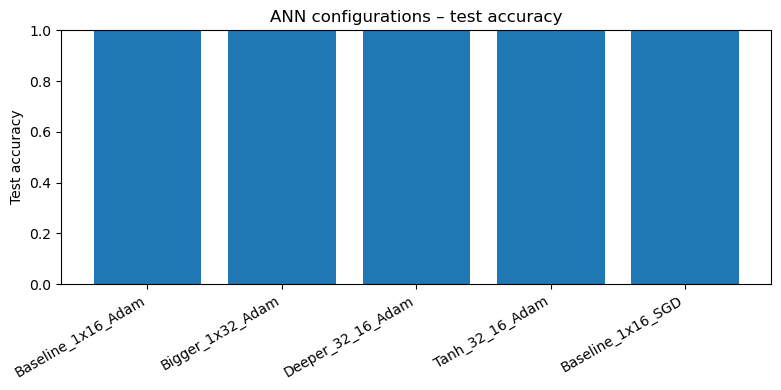

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(results_df["name"], results_df["test_accuracy"])
plt.xticks(rotation=30, ha='right')
plt.ylabel("Test accuracy")
plt.ylim(0, 1)
plt.title("ANN configurations – test accuracy")
plt.tight_layout()
plt.show()


In [23]:
def compute_pred_grid(mlp, ndvi, ndbi, ndwi, scaler, patch_size=PATCH_SIZE):
    H, W = ndvi.shape
    rows = H // patch_size
    cols = W // patch_size
    grid = np.zeros((rows, cols), dtype=np.float32)

    for i in range(rows):
        for j in range(cols):
            r = i * patch_size
            c = j * patch_size

            feats = patch_to_features(ndvi, ndbi, ndwi, r, c, size=patch_size)
            if np.any(np.isnan(feats)):
                grid[i, j] = np.nan
                continue

            feats_scaled = scaler.transform(feats.reshape(1, -1))
            p_urban = mlp.predict_proba(feats_scaled)[0, 1]  # prob of class 1 (urban)
            grid[i, j] = p_urban

    return grid


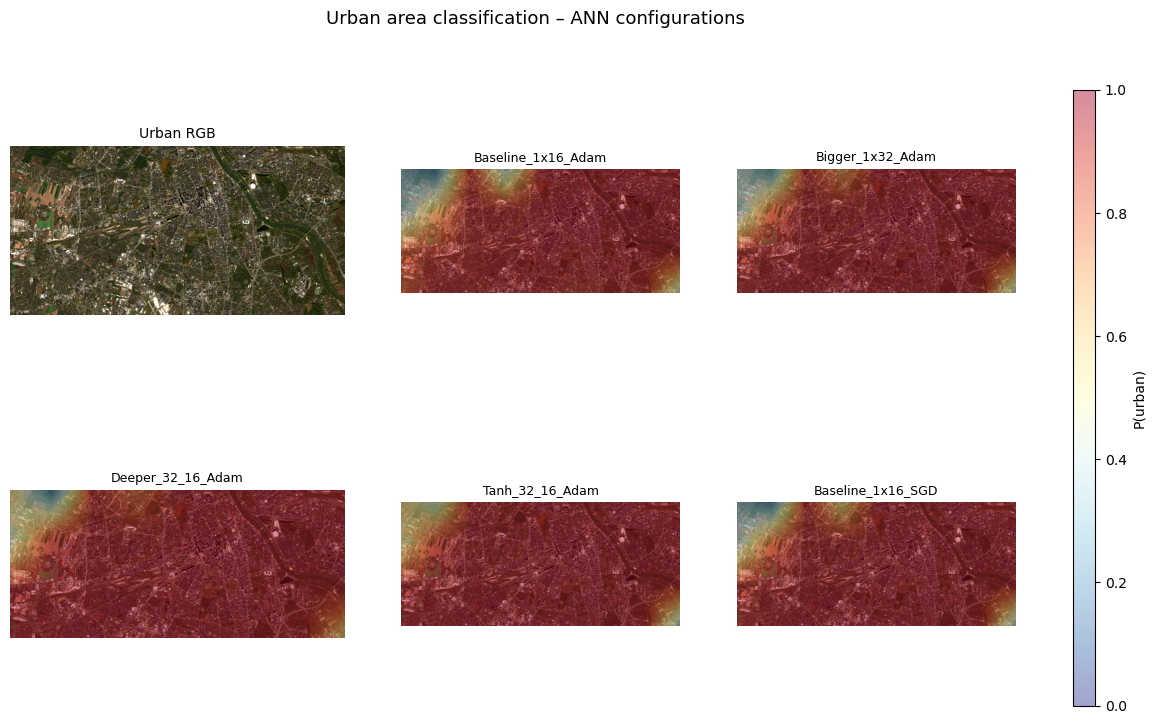

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ---- FIGURE SETUP ----
fig = plt.figure(figsize=(14, 8))

# 2 rows, 4 columns (last col = colorbar)
gs = gridspec.GridSpec(
    2, 4,
    width_ratios=[1.2, 1, 1, 0.08],   # last narrow slot for colorbar
    wspace=0.25,                     # horizontal space
    hspace=0.18                      # vertical space
)

# ---- PANEL 0: Urban RGB ----
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(urb)
ax0.set_title("Urban RGB", fontsize=10)
ax0.axis("off")

# ---- OTHER 5 panels ----
axes_models = [
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[0, 2]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[1, 2]),
]

# ---- Plot overlays ----
im = None
for ax, (name, mask) in zip(axes_models, overlays):
    ax.imshow(urb)
    im = ax.imshow(mask, cmap="RdYlBu_r", alpha=0.45, vmin=0, vmax=1)
    ax.set_title(name, fontsize=9)
    ax.axis("off")

# ---- COLORBAR (full height, better placement) ----
cax = fig.add_subplot(gs[:, 3])        # span both rows
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("P(urban)", fontsize=10)

# ---- SUPER TITLE ----
fig.suptitle("Urban area classification – ANN configurations", fontsize=13, y=0.98)

plt.show()


## consolidate your findings

All ANN configurations achieved very high accuracy, with most models reaching a perfect score, indicating that NDVI, NDBI and NDWI provide a highly separable feature space for distinguishing urban and forest patches. Increasing network depth or width, or switching activation functions, did not improve performance, although Adam consistently converged faster and more reliably than SGD.